<a href="https://colab.research.google.com/github/uhdang/mlim_group_3_final_assignment/blob/main/master_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ToDo

- Exercise #7 - slide 5
- own-product moving window purchase frequencies
- own-category moving window purchase frequencies
- customer embedding (matrix-factorization)
- negative sampling instead of using all products for each shopper
- Crossvalidation
- PCA for product vectors included as feature and then remove product
- discount from same category
- price elasticity (own and cross product/category)
- promotion in substitute or complementary category

Put code in functions or maybe classes

In [1]:
# !pip install scikit-learn --upgrade
# !pip install lightgbm --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load Data

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  baskets = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet")
  coupons = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parquet")
  coupon_index = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parquet")
else:
  file_path = "./data/"

  baskets_pq = "baskets.parquet"
  coupons_pq = "coupons.parquet"
  coupon_index_pq = "coupon_index.parquet"

  baskets = pd.read_parquet(file_path + baskets_pq)
  coupons = pd.read_parquet(file_path + coupons_pq)
  coupon_index = pd.read_parquet(file_path + coupon_index_pq)

  print(f"baskets_df: {b_df.shape}")
  print(f"coupons_df: {c_df.shape}")
  print(f"coupon_index_df: {ci_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# baskets = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet")
# coupons = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parquet")
# coupon_index = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parquet")

In [5]:
baskets['target'] = 1

# Split Data

In [6]:
weeks = 89 
shoppers = 100

baskets_train = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week<weeks), :]
baskets_test = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week>=weeks), :]

coupons_train = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week<weeks), :]
coupons_test = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week>=weeks), :]

In [7]:
cat_columns = ['shopper', 'product']

baskets_train[cat_columns] = baskets_train[cat_columns].astype('category')
baskets_test[cat_columns] = baskets_test[cat_columns].astype('category')
coupons_train[cat_columns] = coupons_train[cat_columns].astype('category')
coupons_test[cat_columns] = coupons_test[cat_columns].astype('category')

baskets[cat_columns] = baskets[cat_columns].astype('category')
coupons[cat_columns] = coupons[cat_columns].astype('category')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Feature Engineering

In [8]:
original_price = baskets.groupby('product', as_index=False).price.max().rename(columns={'price': 'original_price'})
total_count_of_product = baskets_train.groupby(['shopper', 'product']).product.count().to_frame('total_count_of_product').reset_index()
reordered = (baskets_train.groupby(['shopper']).product.value_counts()>1).astype(int)
average_price_per_shopper = baskets_train.groupby(['shopper']).price.mean().to_frame('average_price_per_shopper').reset_index()
average_basket_size = baskets_train.groupby(['shopper', 'week']).product.count().groupby('shopper').mean().to_frame('average_basket_size').reset_index()
unique_products_per_shopper = baskets_train.groupby(['shopper']).product.nunique()
ratio_of_reordered_per_shopper = (reordered.groupby('shopper').sum() / unique_products_per_shopper).to_frame('ratio_of_reordered').reset_index()

ratio_of_reordered_per_product = total_count_of_product.copy()
ratio_of_reordered_per_product['total_count_of_product'] = total_count_of_product['total_count_of_product'] / (baskets_train.week.max()+1)
ratio_of_reordered_per_product.rename(columns={'total_count_of_product': 'ratio_of_reordered_per_product'}, inplace=True)

reordered = reordered.to_frame('reordered').reset_index()
unique_products_per_shopper = unique_products_per_shopper.to_frame('unique_products_per_shopper').reset_index()

# window-average -> feature which give less probability to products wich haven't been purchased for a long time -> maybe relates to category as shopper has changed to product in similar category
# add average week interval for each product and shopper -> frequency | maybe not necessary, basically just total_count/weeks, probably already covered by model
# WoE

# Product2Vec

## Step 1
Create a list of baskets.

In [9]:
# create a list of baskets
shoppers_p2v = 10000
baskets_p2v = baskets.loc[(baskets.shopper.isin(list(range(shoppers_p2v)))) & (baskets.week<weeks), :][['week', 'shopper', 'product']]

basket_values = baskets_p2v.sort_values(['week', 'shopper']).values
keys = baskets_p2v.week.astype(str) + '_' + baskets_p2v.shopper.astype(str)
_, index = np.unique(keys, True)
basket_arr = np.split(basket_values[:, 2].astype('str'), np.sort(index))[1:]

In [10]:
# streamer class to fill word2vec list by list
class DataStreamer():
    def __init__(self, data):
        self.data = data
        
    def __iter__(self):
        for basket in self.data:
            yield basket.tolist()

## Step 2


In [11]:
from gensim.models import Word2Vec

In [12]:
datastr = DataStreamer(basket_arr)

model = Word2Vec(
    sentences=datastr, 
    size=100, 
    window=20, # max. size of basket 
    min_count=1,
    negative=2, 
    sample=0,
    sg=1,
    workers=4
)

In [13]:
model.wv.most_similar(positive='76')

[('71', 0.6579920053482056),
 ('74', 0.6431897878646851),
 ('72', 0.6179654002189636),
 ('78', 0.6097676753997803),
 ('79', 0.5975868701934814),
 ('75', 0.5926647186279297),
 ('73', 0.5740009546279907),
 ('77', 0.5290572047233582),
 ('70', 0.44407159090042114),
 ('166', 0.2017422318458557)]

In [14]:
product_keys = [str(product) for product in range(250)]
product_vectors = model.wv[product_keys]

## Step 3: Assigning Categories

### Substitutes | Similar Products

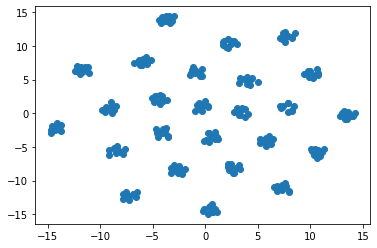

In [15]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(product_vectors)
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(product_vectors)
kmeans.labels_

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22,
       22, 22, 22, 22, 22

In [17]:
# Generate a product category
products = [product for product in range(250)]
prods_cat_table = pd.DataFrame(data=products, columns=["product"])
prods_cat_table["category"] = kmeans.labels_
prods_cat_table[['product', 'category']] = prods_cat_table[['product', 'category']].astype('category')

In [18]:
prods_cat_table.head()

,product,category
0,0,12
1,1,12
2,2,12
3,3,12
4,4,12


### Complementary Products

In Progress

In [19]:
# w_in
w_in = model.wv.vectors

# w_out
w_out = model.trainables.syn1neg

In [20]:
w_in.shape

(250, 100)

In [21]:
np.dot(w_in[0], w_out[0])

-4.46165

In [22]:
np.argmax([np.dot(w_in[0], context) for context in w_out])

26

In [23]:
model.wv.most_similar('105')

[('101', 0.702397882938385),
 ('106', 0.6450371146202087),
 ('102', 0.5996502637863159),
 ('104', 0.587533175945282),
 ('100', 0.575513482093811),
 ('108', 0.5638555884361267),
 ('107', 0.5464397668838501),
 ('103', 0.5124387741088867),
 ('109', 0.4956483542919159),
 ('9', 0.2718198299407959)]

In [24]:
model.wv.vocab['105'].index

0

In [25]:
model.wv.vocab['138'].index

26

In [26]:
model.wv.index2word[26]

'138'

In [27]:
model.predict_output_word(['3'])

[('197', 0.014731817),
 ('66', 0.014103713),
 ('138', 0.013932436),
 ('105', 0.013757167),
 ('222', 0.013572404),
 ('126', 0.012606506),
 ('249', 0.012148581),
 ('86', 0.011622194),
 ('79', 0.0115237385),
 ('48', 0.011387495)]

# Set Up Training Table

In [28]:
full_df_train = (baskets_train
           .merge(
               coupons_train, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
           .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
           .rename(columns={'_merge': 'coupon'})
)

full_df_train['discount'].fillna(0, inplace=True)

In [29]:
df1 = pd.DataFrame({'key':np.ones(weeks), 'week':list(range(weeks))})
df2 = pd.DataFrame({'key':np.ones(shoppers), 'shopper':list(range(shoppers))})
df3 = pd.DataFrame({'key':np.ones(250), 'product':list(range(250))})
df4 = full_df_train.copy()

X_train = (pd
           .merge(df1, df2, on='key')
           .merge(df3, on='key')
           .merge(full_df_train, on=['week', 'shopper', 'product'], how='left')[full_df_train.columns]
)

Combine all features

In [30]:
X_train = (X_train
           .merge(prods_cat_table, on=['product'], how='left')
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           )

In [31]:
X_train.head()

,week,shopper,product,price,target,discount,coupon,category,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper
0,0,0,0,NaN,NaN,NaN,NaN,12,688,0,NaN,0.000000,0.722222,587.203947,8.539326,54
1,0,0,1,NaN,NaN,NaN,NaN,12,560,0,NaN,0.000000,0.722222,587.203947,8.539326,54
2,0,0,2,NaN,NaN,NaN,NaN,12,773,0,NaN,0.000000,0.722222,587.203947,8.539326,54
3,0,0,3,NaN,NaN,NaN,NaN,12,722,0,NaN,0.000000,0.722222,587.203947,8.539326,54
4,0,0,4,NaN,NaN,NaN,NaN,12,620,8,1.0,0.089888,0.722222,587.203947,8.539326,54


In [32]:
X_train['discount'].fillna(0, inplace=True)
X_train['price'].fillna(X_train.original_price*(1-X_train.discount/100), inplace=True)
X_train['reordered'].fillna(0, inplace=True)
X_train['coupon'].fillna('No', inplace=True)
X_train['target'].fillna(0, inplace=True)

In [33]:
# Count weeks since last order of that product
addkey = X_train.groupby(['shopper','product']).target.apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
X_train['weeks_since_prior_order'] = X_train.target.eq(0).groupby([X_train['shopper'], X_train['product'], addkey]).cumcount().add(1) # .cumsum()

In [34]:
X_train.head(3)

,week,shopper,product,price,target,discount,coupon,category,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper,weeks_since_prior_order
0,0,0,0,688.0,0.0,0.0,No,12,688,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
1,0,0,1,560.0,0.0,0.0,No,12,560,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
2,0,0,2,773.0,0.0,0.0,No,12,773,0,0.0,0.0,0.722222,587.203947,8.539326,54,1


In [35]:
X_train.drop('week', inplace=True, axis=1)
y_train = X_train.pop('target')

# Set Up Test Table

In [36]:
full_df_test = (baskets_test
           .merge(
               coupons_test, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
           .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
           .rename(columns={'_merge': 'coupon'})
)

full_df_test['discount'].fillna(0, inplace=True)

In [37]:
df1 = pd.DataFrame({'key': np.ones(len(baskets_test.week.unique())), 'week': baskets_test.week.unique()})
df2 = pd.DataFrame({'key': np.ones(shoppers), 'shopper': list(range(shoppers))})
df3 = pd.DataFrame({'key': np.ones(250), 'product': list(range(250))})

X_test = (pd
          .merge(df1, df2, on='key')
          .merge(df3, on='key')
          .merge(full_df_test, on=['week', 'shopper', 'product'], how='left')[full_df_test.columns]
)

In [38]:
X_test = (X_test
          .merge(prods_cat_table, on=['product'], how='left')
          .merge(original_price, on=['product'], how='left')
          .merge(total_count_of_product, on=['shopper', 'product'], how='left')
          .merge(reordered, on=['shopper', 'product'], how='left')
          .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
          .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
          .merge(average_price_per_shopper, on=['shopper'], how='left')
          .merge(average_basket_size, on=['shopper'], how='left')
          .merge(unique_products_per_shopper, on=['shopper'], how='left')
)

In [39]:
X_test['discount'].fillna(0, inplace=True)
X_test['price'].fillna(X_test.original_price*(1-X_test.discount/100), inplace=True)
X_test['reordered'].fillna(0, inplace=True)
X_test['coupon'].fillna('No', inplace=True)
X_test['target'].fillna(0, inplace=True)

In [40]:
# Take weeks_since_prior_order from last available week in training and add 1
last_weeks_since_prior_order = X_train.groupby(['shopper', 'product']).weeks_since_prior_order.last() + 1

X_test = X_test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

In [41]:
X_test.drop('week', inplace=True, axis=1)
y_test = X_test.pop('target')

# One-Hot Encoding Products

LightGBM handles categorical data, so no separata encoding necessary

In [42]:
# from sklearn.preprocessing import OneHotEncoder

In [43]:
# enc = OneHotEncoder(sparse=False)

# encodings = X_train.select_dtypes(exclude=np.number).columns.tolist()
# # encoded = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(X_train[encodings]))
# encoded = pd.DataFrame(enc.fit_transform(X_train[encodings]))
# encoded.columns = enc.get_feature_names(encodings)

# X_train = pd.concat([X_train, encoded], axis=1).drop(encodings, axis=1)

# X_train = X_train.apply(pd.to_numeric)

# X_train.head(3)

# Training

In [44]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

In [45]:
from collections import Counter

# count examples in each class
counter = Counter(y_train)
class_imbalance = counter[0] / counter[1] # parameter to counter class imbalance

lgb_clf = LGBMClassifier(
    scale_pos_weight=1 # =class_imbalance
    )

In [46]:
categorical = X_train.select_dtypes(exclude=np.number).columns.tolist()

for cats in categorical:
  X_train[cats] = X_train[cats].astype('category')
  X_test[cats] = X_test[cats].astype('category')

In [47]:
lgb_clf.fit(X_train, y_train, categorical_feature=categorical)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'coupon', 'product', 'shopper']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [48]:
lgb_clf.score(X_train, y_train)

0.9726444943820225

In [49]:
lgb_clf.score(X_test, y_test)

0.97064

## Evaluation

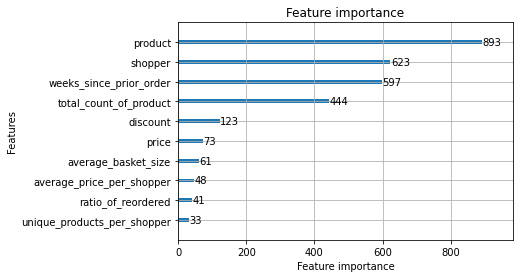

In [50]:
lgb.plot_importance(lgb_clf, max_num_features=10)

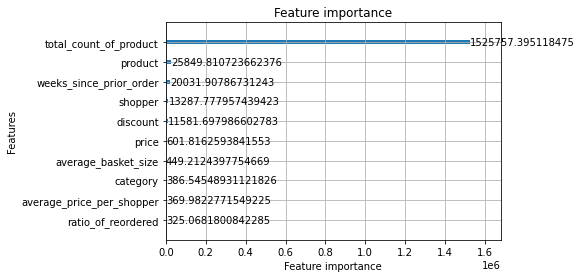

In [51]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

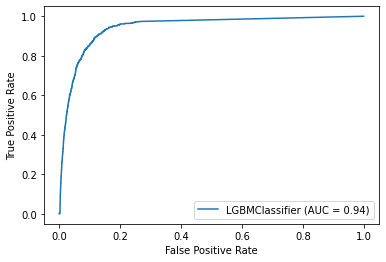

In [52]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(estimator=lgb_clf, X=X_test, y=y_test)

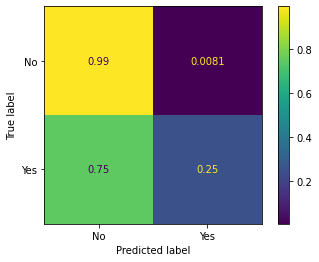

In [53]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [54]:
confusion

array([[24085,   196],
       [  538,   181]])

In [55]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# Precision
PPV = TP/(TP+FP)
# False discovery rate -> 1-Precision
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [56]:
print(f'Precision: {PPV:.4f}')
print(f'Recall (TPR): {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')

Precision: 0.4801
Recall (TPR): 0.2517
TNR: 0.9919
FPR: 0.0081
FNR: 0.7483


## evaluating specific examples

In [57]:
pd.DataFrame(lgb_clf.predict_proba(X_test))

,0,1
0,0.999999,0.000001
1,0.999999,0.000001
2,0.999999,0.000001
3,0.999999,0.000001
4,0.908124,0.091876
...,...,...
24995,0.999999,0.000001
24996,0.583541,0.416459
24997,0.999999,0.000001
24998,0.999999,0.000001


In [58]:
pred_frame = pd.concat((X_test, y_test, pd.DataFrame(lgb_clf.predict_proba(X_test))[1]), axis=1)[['shopper', 'product', 'target', 'weeks_since_prior_order', 1]]

In [59]:
pred_frame.tail(10)

,shopper,product,target,weeks_since_prior_order,1
24990,99,240,0.0,90,0.000001
24991,99,241,0.0,90,0.000001
24992,99,242,0.0,44,0.011380
24993,99,243,0.0,90,0.000001
24994,99,244,0.0,90,0.000001
24995,99,245,0.0,90,0.000001
24996,99,246,1.0,12,0.416459
24997,99,247,0.0,90,0.000001
24998,99,248,0.0,90,0.000001
24999,99,249,0.0,90,0.000001


In [60]:
pred_frame.loc[(pred_frame['shopper']==0) & (pred_frame['product']==4)]

,shopper,product,target,weeks_since_prior_order,1
4,0,4,0.0,19,0.091876


In [61]:
X_train.loc[
            (X_train['shopper']==0) 
            & (X_train['product']==7)
]

,shopper,product,price,discount,coupon,category,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper,weeks_since_prior_order
7,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
25007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,2
50007,0,7,540.4,30.0,Yes,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,3
75007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,4
100007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,85
2125007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,86
2150007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,87
2175007,0,7,772.0,0.0,No,12,772,0,0.0,0.0,0.722222,587.203947,8.539326,54,88


In [62]:
# from sklearn.inspection import plot_partial_dependence

# plot_partial_dependence(estimator=lgb_clf, X=X_test, features=['weeks_since_prior_order', 'discount']) -> only works with sklearn 0.24, so not working for google colab 

# Hypertuning

In [63]:
# !sudo apt-get install build-essential swig
# !pip install auto-sklearn==0.12

## AutoML

In [64]:
# import autosklearn.classification

In [65]:
# from autosklearn.experimental.askl2 import AutoSklearn2Classifier

In [66]:
# automl = AutoSklearn2Classifier(n_jobs=-1)
# automl.fit(X_train, y_train)

In [67]:
# y_hat = automl.predict_proba(X_test)

In [68]:
# pred = [1 if prediction[1]>0.5 else 0 for prediction in y_hat ] 

In [69]:
# auto_confusion = confusion_matrix(y_test, pred) 

In [70]:
# auto_confusion

In [71]:
# FP = auto_confusion[0][1]
# FN = auto_confusion[1][0]
# TP = auto_confusion[1][1]
# TN = auto_confusion[0][0]

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # Precision
# PPV = TP/(TP+FP)
# # False discovery rate -> 1-Precision
# FDR = FP/(TP+FP)

# # Overall accuracy
# ACC = (TP+TN)/(TP+FP+FN+TN)

# print(f'TPR: {TPR:.4f}')
# print(f'TNR: {TNR:.4f}')
# print(f'FPR: {FPR:.4f}')
# print(f'FNR: {FNR:.4f}')
# print(f'Precision: {PPV:.4f}')
# print(f'False discovery rate: {FDR:.4f}')

In [72]:
# !pip install --quiet optuna

# import optuna

In [73]:
# clf = LGBMClassifier()

# param_distributions = {
#     'n_estimators': optuna.distributions.IntUniformDistribution(10, 500),
#     'num_leaves': optuna.distributions.IntUniformDistribution(2, 50),
#     'min_data_in_leaf': optuna.distributions.IntUniformDistribution(100, 400),
#     'feature_fraction': optuna.distributions.LogUniformDistribution(0.5, 1),
# #     'max_depth': optuna.distributions.IntUniformDistribution(-1, 200),
#     'subsample': optuna.distributions.LogUniformDistribution(0.5, 1),
# }

# optuna_search = optuna.integration.OptunaSearchCV(
#     estimator=clf, 
#     param_distributions=param_distributions, 
#     n_trials=50, 
#     timeout=7200,
#     cv=
# )

# optuna_search.fit(X_train, y_train)